##Import Library

In [1]:
import os
import shutil
import random
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Load Data

In [ ]:
# Path ke dataset
dataset_path = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/flowers'

# Cek jumlah gambar dalam dataset
num_images = sum([len(files) for _, _, files in os.walk(dataset_path)])
print(f"Total gambar dalam dataset: {num_images}")


Total gambar dalam dataset: 4317


In [ ]:
# Inisialisasi dictionary untuk menyimpan jumlah gambar per kelas
class_counts = {}

# Loop untuk setiap folder (kelas)
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([
            filename for filename in os.listdir(class_folder)
            if os.path.isfile(os.path.join(class_folder, filename))
        ])
        class_counts[class_name] = num_images

# Cetak jumlah gambar per kelas
for class_name, count in class_counts.items():
    print(f"Kelas '{class_name}': {count} gambar")

Kelas 'tulip': 984 gambar
Kelas 'rose': 784 gambar
Kelas 'daisy': 764 gambar
Kelas 'dandelion': 1052 gambar
Kelas 'sunflower': 733 gambar


In [ ]:
# Inisialisasi dictionary untuk menyimpan resolusi gambar per kelas
image_resolutions = {}

# Loop setiap kelas
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        image_files = [
            f for f in os.listdir(class_folder)
            if os.path.isfile(os.path.join(class_folder, f))
        ]
        if image_files:  # Pastikan folder tidak kosong
            random_image = random.choice(image_files)
            image_path = os.path.join(class_folder, random_image)

            with Image.open(image_path) as img:
                resolution = img.size  # (width, height)
                image_resolutions[class_name] = {
                    'filename': random_image,
                    'resolution': resolution
                }

# Tampilkan resolusi gambar acak dari tiap kelas
for class_name, info in image_resolutions.items():
    print(f"Kelas '{class_name}': {info['filename']} - Resolusi: {info['resolution']}")

Kelas 'tulip': 5811004432_266f0f0c6f.jpg - Resolusi: (500, 321)
Kelas 'rose': 14460517566_783dbf23b8_n.jpg - Resolusi: (240, 159)
Kelas 'daisy': 3386988684_bc5a66005e.jpg - Resolusi: (500, 333)
Kelas 'dandelion': 3454102259_957ecd0a9b.jpg - Resolusi: (500, 344)
Kelas 'sunflower': 2883115609_5a69357b5d_m.jpg - Resolusi: (176, 240)


##Splitting Data

In [ ]:
# Path ke dataset utama
dataset_path = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/flowers'
train_path = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/train'
valid_path = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/valid'
test_path = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/test'

# Buat direktori train, valid, test
for path in [train_path, valid_path, test_path]:
    os.makedirs(path, exist_ok=True)

# Ambil semua class
class_labels = os.listdir(dataset_path)

for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    images = os.listdir(class_path)

    # Split data
    train_files, test_valid_files = train_test_split(images, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_valid_files, test_size=0.5, random_state=42)

    # Buat direktori masing-masing kelas dalam train, valid, test
    for folder in [train_path, valid_path, test_path]:
        os.makedirs(os.path.join(folder, label), exist_ok=True)

    # Pindahkan file ke masing-masing folder
    for file in train_files:
        shutil.move(os.path.join(class_path, file), os.path.join(train_path, label, file))
    for file in valid_files:
        shutil.move(os.path.join(class_path, file), os.path.join(valid_path, label, file))
    for file in test_files:
        shutil.move(os.path.join(class_path, file), os.path.join(test_path, label, file))

print("Splitting dataset selesai!")


Splitting dataset selesai!


In [ ]:
def count_images(directory):
    total = 0
    for label in os.listdir(directory):
        total += len(os.listdir(os.path.join(directory, label)))
    return total

print(f"Total gambar di Train Set: {count_images(train_path)}")
print(f"Total gambar di Validation Set: {count_images(valid_path)}")
print(f"Total gambar di Test Set: {count_images(test_path)}")


Total gambar di Train Set: 3452
Total gambar di Validation Set: 430
Total gambar di Test Set: 435


##Augmentasi

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path dataset setelah splitting
train_dir = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/train'
valid_dir = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/valid'
test_dir = '/content/gdrive/MyDrive/Dicoding_IMG_Dataset/test'

# Ukuran gambar
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# ImageDataGenerator untuk Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Untuk Validation & Test
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dari folder (Train, Validation, Test)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cek jumlah kelas
num_classes = len(train_generator.class_indices)
print(f"Jumlah kelas dalam dataset: {num_classes}")


Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.
Jumlah kelas dalam dataset: 5


##Modeling

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    # Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Menampilkan summary dari model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,706,181 (6.51 MB)

 Trainable params: 1,703,685 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

#Compile Model

In [17]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


##Callbacks

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback: EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

# Mengurangi learning rate jika val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

callbacks = [reduce_lr, early_stopping]


##Train Model

In [19]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1145s 21s/step - accuracy: 0.4424 - loss: 1.8105 - val_accuracy: 0.2442 - val_loss: 3.1119 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5445 - loss: 1.2747 - val_accuracy: 0.2442 - val_loss: 3.3965 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5727 - loss: 1.1795 - val_accuracy: 0.2442 - val_loss: 2.9478 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6079 - loss: 1.0649 - val_accuracy: 0.3140 - val_loss: 2.3202 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6585 - loss: 0.9276 - val_accuracy: 0.3372 - val_loss: 1.6253 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6521 - loss: 0.9012 - val_accuracy: 0.3558 - val_loss: 1.6880 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6926 - loss: 0.8195 - val_

## Plotting & Evaluasi

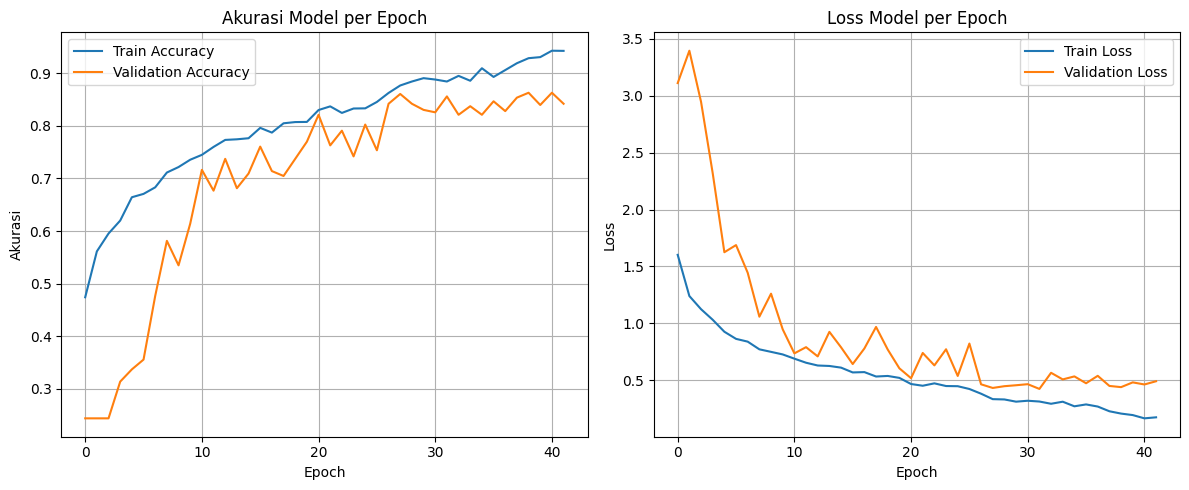

In [22]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Ambil prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes

# Label nama kelas (opsional)
class_labels = list(test_generator.class_indices.keys())

# Tampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 617ms/step
              precision    recall  f1-score   support

       daisy       0.94      0.84      0.89        77
   dandelion       0.91      0.84      0.87       106
        rose       0.81      0.73      0.77        79
   sunflower       0.79      0.95      0.86        74
       tulip       0.81      0.88      0.84        99

    accuracy                           0.85       435
   macro avg       0.85      0.85      0.85       435
weighted avg       0.85      0.85      0.85       435



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step


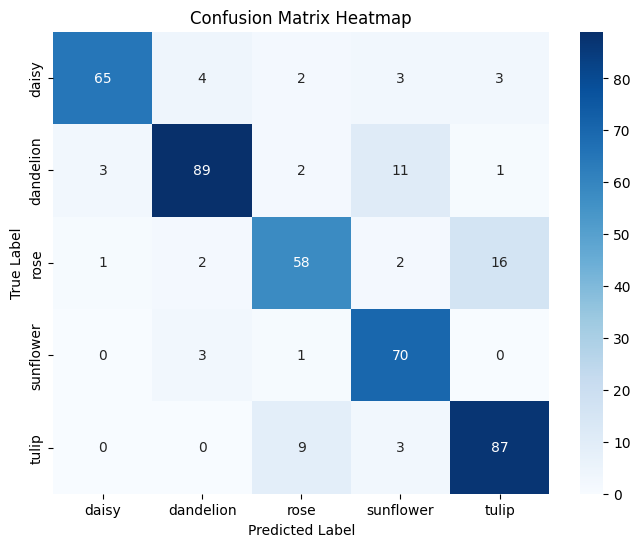

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Prediksi menggunakan model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# 2. Ambil label sebenarnya dari test_generator
y_true = test_generator.classes

# 3. Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Ambil nama kelas dari test_generator
class_names = list(test_generator.class_indices.keys())

# 5. Tampilkan heatmap-nya
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Save model

In [25]:
model.export('model1_saved')

Saved artifact at 'model1_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136544662412880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662409616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662415184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662412112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662413072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662411920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662416528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662417104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662417296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662416144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136544662409808

In [26]:
import tensorflow as tf

# Load SavedModel dan konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("model1_saved")
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model1.tflite", "wb") as f:
    f.write(tflite_model)

In [5]:
class_indices = train_generator.class_indices
print(class_indices)


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [6]:
labels = [''] * len(class_indices)
for class_name, idx in class_indices.items():
    labels[idx] = class_name

with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")


In [27]:
pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found exi

In [2]:
!tensorflowjs_converter --input_format=tf_saved_model model1_saved/ tfjs_model/


2025-04-08 03:31:40.377484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744083100.434450   26453 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744083100.445556   26453 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744083100.474473   26453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744083100.474527   26453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744083100.474536   26453 computation_placer.cc:177] computation placer alr

## Inference

Prediksi: sunflower (99.96%)


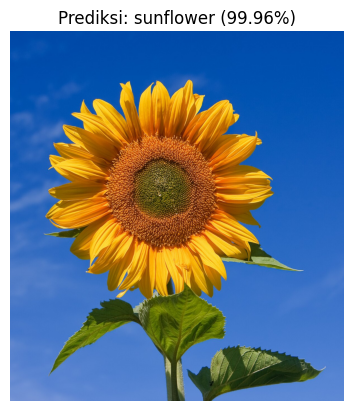

In [9]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="/content/model1.tflite")
interpreter.allocate_tensors()

# Load labels
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# input
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Baca gambar dan resize ke 224x224
image_path = "/content/Sunflower_sky_backdrop.jpg"
image = Image.open(image_path).convert("RGB")
resized_image = image.resize((224, 224))
input_array = np.array(resized_image, dtype=np.float32) / 255.0
input_data = np.expand_dims(input_array, axis=0)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data[0])
predicted_label = labels[predicted_index]
confidence = output_data[0][predicted_index]

# Cetak hasil dan tampilkan gambar
print(f"Prediksi: {predicted_label} ({confidence*100:.2f}%)")

# Tampilkan gambar dengan label prediksi
plt.imshow(image)
plt.title(f"Prediksi: {predicted_label} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()
